##  Chapter 8: Linear Unsupervised Learning

# 8.4 Recommender Systems

In this Section we discuss the fundamental linear *Recommender System*, a popular unsupervised learning framework commonly employed by businesses to help automatically recommend products and services to their customers.  From the vantage of machine learning however, the basic Recommender System detailed here is simply a slight twist on  our core unsupervised learning technique: Principal Component Analysis (PCA).  

## Introduction and motivation

Recommender systems are heavily used in e-commerce today, providing customers with personalized recommendations for products and services by using a consumer's previous purchasing and rating history, along with those of similar customers.  For instance, a movie provider like Netflix with millions of users and tens of thousands of movies, records users' reviews and ratings (typically in the form of a number on a scale of 1-5 with 5 being the most favorable rating) in a large matrix such as the one illustrated below in the Figure. These matrices are very sparsely populated, since an individual consumer has likely rated only a small portion of the movies available. With this data available, online movie and commerce sites often use the unsupervised learning technique we discuss in this Section as their main technique for making personalized recommendations to customers regarding what they might like to watch / consume next. With the technique for producing personalized recommendations we discuss here - typically referred to as a *Recommender System* - we aim to intelligently guess the values of every missing entry in the ratings matrix (we *complete* the matrix).  Then, in order to recommend a new product to a given user, we examine our completely filled ratings matrix for products we have predicted the user would highly rate (and thus enjoy) and recommend these.  

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/Fig_9_11.png' width="70%" height="auto" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em> A prototypical movie rating matrix is very sparsely populated, with each user having rated only a very small number of films. In this diagram movies are listed along rows with users along columns.  In order to properly recommend movies for users to watch we try to intelligently guess the missing values of this matrix, and then recommend movies that we predict users would highly rate (and therefore enjoy the most).
  </em>  </figcaption> 
</figure>

In [2]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ortho_group  # Requires version 0.18 of scipy

# custom libs
from mlrefined_libraries import unsupervised_library as unsuplib
from mlrefined_libraries import math_optimization_library as optlib
optimizers = optlib.optimizers
static_plotter = optlib.static_plotter.Visualizer()
datapath = '../../mlrefined_datasets/unsuperlearn_datasets/'

# plotting utilities
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy

# This is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## Formal modeling

In what follows we will use the familiar notation $\mathbf{x}_1,...,\mathbf{x}_P$ to denote our input data, each of which has dimension $N$.   Here $\mathbf{x}_p$ is our $p^{th}$ user's rating vector of - and is $N$ dimensional where $N$ is the total number of products / services available to be rated - and each is very sparsely populated (with whatever ratings user $p$ has input into the system).  Formally we can denote the index set of those products / services the $p^{th}$ user has rated - or in other words the index set of those non-empty entries of $\mathbf{x}_p$ - as

\begin{equation}
\Omega = \left \{\,\,\left(j,p\right)\,\,\rvert \,\,x_{j,\,p}  \,\,\text{exists}  \right \}.
\end{equation}

Note here that $x_{j,\,p}$ denotes the $j^{th}$ entry of the vector $\mathbf{x}_p$.


Stacking these user-rating vectors column-wise gives us our ratings matrix that we wish to complete

\begin{equation}
\mathbf{X} = \begin{bmatrix} 
\vert \,\,\,\,\,\, \vert \,\,\,\,\,...\,\,\,\,\vert \\
\mathbf{x}_1 \,\, \mathbf{x}_2 \,\,...\,\,\mathbf{x}_P \\
\vert \,\,\,\,\,\, \vert \,\,\,\,\,...\,\,\,\,\vert
\end{bmatrix}.
\end{equation}

In order to complete a sparsely populated ratings matrix effectively - because the data we are aiming to fill in is literally missing - we have no choice but to make assumptions about how users' tastes behave in general.   The most common / simplest assumption we can make - and the one we discuss here - is that every user's tastes can be expressed as a linear combination of some small set of fundamental user taste-profiles.  For example, in the case of movies these profiles could include the prototypical romance movie lover, prototypical comedy movie lover, action movie lover, etc.,  The relatively small number of such categories or user types compared to the total number of users or movies / products / etc., in a ratings matrix, provides a useful framework to intelligently guess at the ratings matrix's missing values. 

How does this assumption help us complete the ratings matrix?  In order to find out we need to translate this intuitive assumption into mathematics.  When stated mathematically this assumption says that there are some set of $K < N$ prototypical user-rating profile basis vectors $\mathbf{c}_1,\,\mathbf{c}_2,\,..,\,\mathbf{c}_K$ so that we can express (approximately) every *complete* user-profile vector (given also the ideal weights in each linear combination) as 

\begin{equation}
\sum_{n=1}^K \mathbf{c}_n w_{n,\,p} \approx \mathbf{x}_p  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P.
\end{equation}

If we stack our basis vectors together columnwise into a $N\times K$ matrix $\mathbf{C}$ this line above can be communicated more compactly as 

\begin{equation}
 \mathbf{C} \mathbf{w}_{p} \approx \mathbf{x}_p  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P.
\end{equation}

From here we could then propose to square the difference of each desired approximation above and sum the result (which would give precisely the Least Squares cost function for PCA discussed in the previous Section).  But remember in the case of Recommender Systems we only have entries of $\mathbf{X}$ belonging to the index set $\Omega$.  For each $p$ we will denote the desired approximation over only this index set as

\begin{equation}
\left.\left\{ \mathbf{C} \mathbf{w}_{p} \approx \mathbf{x}_p \right\}\right\vert_{\,\Omega}  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P.
\end{equation}

Squaring the difference between both sides of the above we can then form a Least Squares cost function for learning the parameters of our Recommender System (that closely mirrors the one we derived for PCA in the previous Section) as


\begin{equation}
g\left(\mathbf{w}_1,...,\mathbf{w}_P,\mathbf{C}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \left.\left\{  \mathbf{C} \mathbf{w}_{p} - \mathbf{x}_p \right\}\right\vert_{\,\Omega_p}\right\Vert_2^2.
\end{equation}

We can call this the *Recommender Systems Least Squares* cost function.

Note from here it is not possible, as we did with PCA in the previou Section, refine our pursuit to *orthogonal bases* (a pursuit we saw previously that led to the autoencoder and - eventually - the classic PCA solution) since we do not have access to every element of the data.

##  Optimizing the Recommender Systems model

So far we have seen how the setup and cost function of the linear Recommender Systems model mirrors PCA very closely.  Now we discuss how to minimize the Least Squares cost function above in order to recover optimal settings for our parameter vectors $\mathbf{w}_1,...,\mathbf{w}_p$ and $\mathbf{c}_1,...,\mathbf{c}_K$.  In the case of PCA, we saw in [Section 8.5](https://jermwatt.github.io/machine_learning_refined/notes/8_Linear_unsupervised_learning/8_5_Classic.html) how the additional assumption that our basis is *orthonormal* allowed us to derive mathematically simple forms for our ideal parameter vectors.  However here the additional wrinkle of the Recommender Systems model - that we only have access to data whose indices lie in the set $\Omega$ - prohibits similar calculations.  Thus in short we must rely on an iterative method for learning ideal parameters here like gradient descent or coordinate / block-coordinate descent.  Here we show a few simple examples of minimizing the Recommender System Least Squares cost via gradient descent.

#### <span style="color:#a50e3e;">Example 1: </span>  Minimizing the Recommender Systems Least Squares cost function by gradient descent

Below we write a `Python` implementation - called `least_squares` - of the Recommender Systems Least Squares cost detailed above.  For the sake of computational efficiency (to avoid explicit for loops) we implement the cost in its matrix form

\begin{equation}
g\left(\mathbf{W},\mathbf{C}\right) = \frac{1}{P} \left \Vert \left.\left\{  \mathbf{C} \mathbf{W} - \mathbf{X} \right\}\right\vert_{\,\Omega_p}\right\Vert_F^2
\end{equation}

where we have stacked the weight vectors together into a $K\times P$ matrix column-wise precisely as done with $\mathbf{C}$ and $\mathbf{X}$.

Notice a few features of our implementation below.  First note that we pack both variable matrices $\mathbf{C}$ and $\mathbf{W}$ into a single list as `w = [C,W]` - and pass this list of matrices in to the function as input.  Second notice the index set `Omega` in line `9`, which contains known values of the data matrix $\mathbf{X}$.  Here in line `9` we literallly use this index set to sum up and square only the values in these indices from the difference $\mathbf{C}\mathbf{W} - \mathbf{X}$.

In [3]:
# an implementation of the least squares cost for recommender systems
# here the weight matrices are loaded in a single list w = [C,W]
def least_squares(w):  
    # strip off C and W parameters
    C = w[0]
    W = w[1]
    
    # compute the least squares cost
    cost = np.sum(((np.dot(C,W) - X).ravel()[Omega])**2)
    return cost/float(np.size(Omega))

Now we construct a simulated ratings matrix for our tests.  This dataset - created via the ``make_random_test_matrix`` below creates a random ratings matrix of any desired size with integer entries in the range 1 to 5.  Then a user-defined percentage ``remove_perc`` of the entries of this matrix is removed, simulating an incomplete ratings matrix.  We first use it to create a small simulated ratings matrix with $P = 10$ and $N = 100$, with $75$% of its entries removed.  

In [4]:
# generate test matrix
def make_random_test_matrix(N,P,remove_perc):
    # make full ratings matrix with integer scores 0 - 5
    X_complete = np.round(5*np.random.rand(N,P))
    X_test = copy.deepcopy(X_complete)

    # remove percentage of entries
    removal_portion = round(remove_perc*np.size(X_complete))
    indices = np.random.permutation(np.size(X_complete))
    Omega = indices[removal_portion:]
    indices = indices[:removal_portion]
    X_test.ravel()[indices] = np.nan
    
    # return both original matrix and incomplete version
    return X_complete, X_test, Omega

Below we use our functionality to make a simulated test ratings matrix of size $N\times P = 100 \times 10$, and that has $75\%$ of its entries removed.

We then run our algorithm on this matrix and plot the cost function history to make sure everything is running properly.  Here we will use $K = 5$ basis elements, half of the number used in generating the data.  Remember: the cost function history here is showing only our approximation to the known entries of the ratings matrix, whose indices lie in the set $\Omega$.

Now we plot the training and testing cost function histories.

<IPython.core.display.Javascript object>


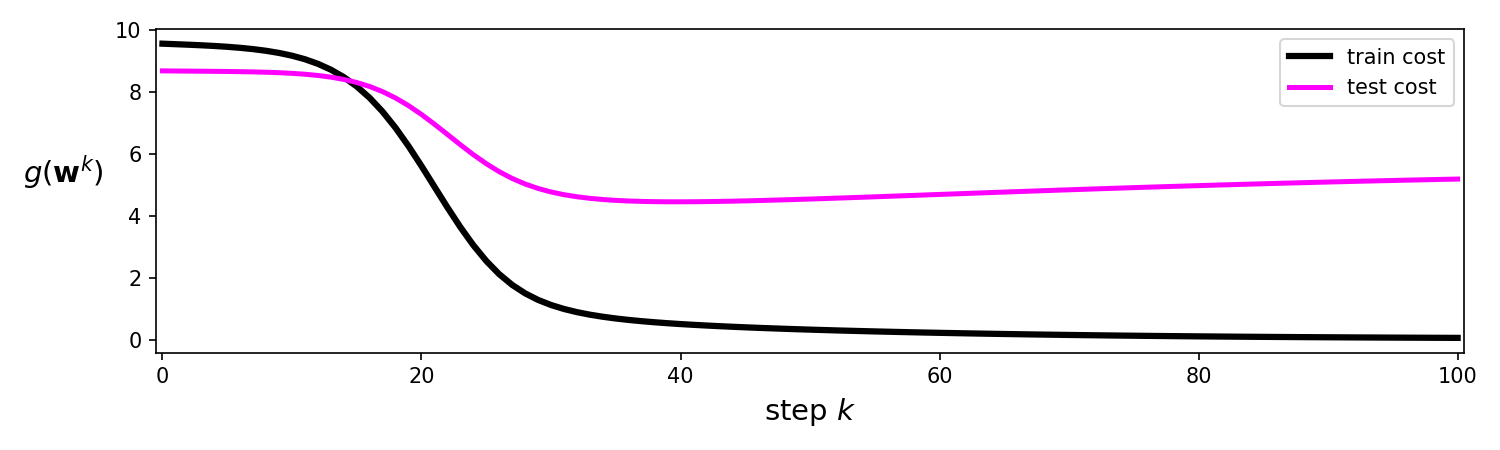

In [5]:
# This code cell will not be shown in the HTML version of this notebook
# make a test matrix
N = 100; P = 10; remove_perc = 0.75; 
X_complete, X_test, Omega_test = make_random_test_matrix(N,P,remove_perc)

# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares; max_its = 100; alpha_choice = 10**(0);
X = copy.deepcopy(X_test); Omega = copy.deepcopy(Omega_test)

# initialize both matrices of parameters
num_elements = 5; scale = 0.1;
C = scale*np.random.randn(X.shape[0],num_elements)
W = scale*np.random.randn(num_elements,X.shape[1])
w = [C,W]

# run gradient descent
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

# error on full dataset
X = copy.deepcopy(X_complete); Omega = np.arange(np.size(X_complete));
test_history = [least_squares(v) for v in weight_history]

# plot the cost function history for a given run
static_plotter.plot_cost_histories([cost_history,test_history],start = 0,points = False,labels = ['train cost','test cost'])

In [6]:
# This code cell will not be shown in the HTML version of this notebook
# run loop over different K
partial_costs = []
full_costs = []

# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares; max_its = 50; alpha_choice = 10**(0);
X = copy.deepcopy(X_test); Omega = copy.deepcopy(Omega_test)
    
# make a test matrix
my_ks = [1,2,3,4,5,6,7,8,9,10,11,12]
for K in my_ks:
    # generate initialization for basis
    C = scale*np.random.randn(X.shape[0],K)
    W = scale*np.random.randn(K,X.shape[1])
    w = [C,W]

    # run gradient descent
    X = copy.deepcopy(X_test); Omega = copy.deepcopy(Omega_test)
    weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

    # error on full dataset
    X = copy.deepcopy(X_complete); Omega = np.arange(np.size(X_complete));
    test_history = [least_squares(v) for v in weight_history]
    ind = np.argmin(test_history)
    
    partial_costs.append(cost_history[ind])
    full_costs.append(test_history[ind])

Now, to get a sense of how well we can learn entries in the matrix we did *not* have to begin with we run the same experiment as above only over a range of values for $K=1,...,9$ and plot the cost function value on a) only the values we are given and b) the entire original matrix.  Afterwards we plot both cost function histories.

<IPython.core.display.Javascript object>


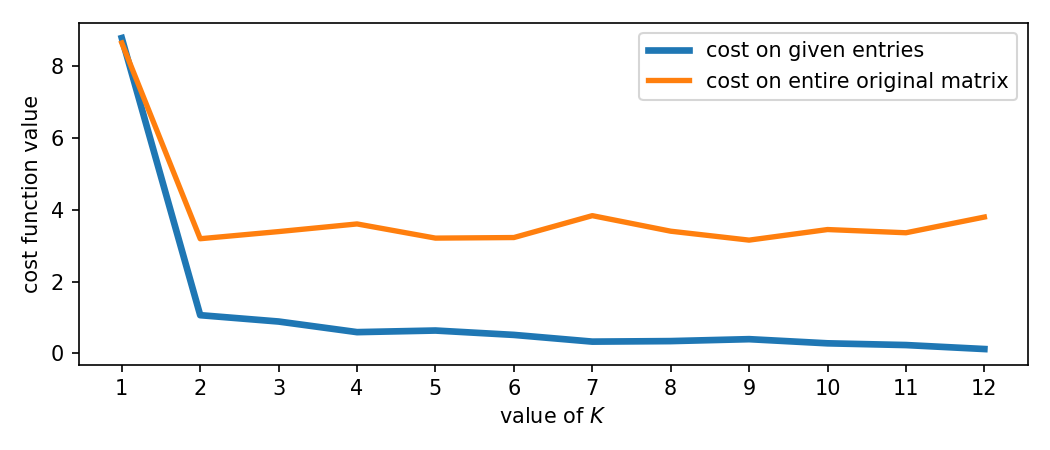

In [7]:
# This code cell will not be shown in the HTML version of this notebook
# plot cost function history
plotter = unsuplib.plot_utilities.Visualizer()
histories = [partial_costs,full_costs]
plotter.compare_histories(histories,label1 = 'cost on given entries',label2 = 'cost on entire original matrix',plot_range = my_ks)

The sort of behavior seen here - where the cost value on the full original matrix reaches a minimum for some intermediary value of $K$ - is quite common.  This is due to the fact that as we increase $K$ here we begin - after a certain value (here $K = 2$) -  to fit very well to our known entries at the expense of generalization (i.e., we begin to fit worse to values we cannot see).  This *overfitting* problem is a common one we will address more systematically in the next Chapter.  